In [10]:
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np

from scipy.stats import skew

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.utils import compute_sample_weight

import statsmodels
import statsmodels.api


import pickle

from utils import remove_top_quantile

In [11]:
df = pd.read_csv('../data/GiveMeSomeCredit-training.csv')
df = df.drop(["Unnamed: 0"], axis=1)

df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


## Imputing
We are going to handle missing values with a median imputing strategy. Observe missing  alues in MonthlyIncome and NumberOfDependents.

In [12]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139999 entries, 0 to 139998
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      139999 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  139999 non-null  float64
 2   age                                   139999 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  139999 non-null  int64  
 4   DebtRatio                             139999 non-null  float64
 5   MonthlyIncome                         112208 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       139999 non-null  int64  
 7   NumberOfTimes90DaysLate               139999 non-null  int64  
 8   NumberRealEstateLoansOrLines          139999 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  139999 non-null  int64  
 10  NumberOfDependents                    136352 non-null  float64
dtype

In [13]:
imputer = SimpleImputer(strategy='median')

columns = df.columns
index = df.index
df = pd.DataFrame(imputer.fit_transform(df))
df.columns = columns
df.index = index

## Outlier removal

First we have to check skewness of data and then trim ouliers.

SeriousDlqin2yrs 3.4811453075385983
RevolvingUtilizationOfUnsecuredLines 104.61629839455564
age 0.1881202035562613
NumberOfTime30-59DaysPastDueNotWorse 22.607004311580404
DebtRatio 95.22217899338378
MonthlyIncome 124.35170894120087
NumberOfOpenCreditLinesAndLoans 1.2044774779464495
NumberOfTimes90DaysLate 23.09448756193742
NumberRealEstateLoansOrLines 3.5575059805957148
NumberOfTime60-89DaysPastDueNotWorse 23.335794978298782
NumberOfDependents 1.62471641207594


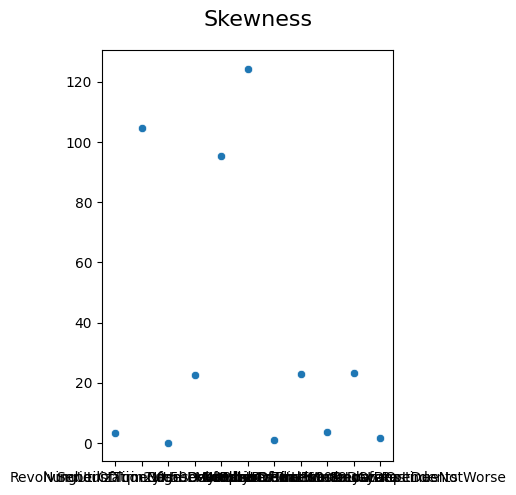

In [14]:
columns = df.columns.to_list()
skew_values = skew(df)

for c, v in zip(columns, skew_values):
    print(c, v)


f, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
f.suptitle('Skewness', fontsize=16)

sns.scatterplot(x=columns, y=skew_values)

plt.tight_layout()
plt.show()

We can observe big imbalance in variables denoting number of times customer had late payments. We are not going to trim those variables as they might be of an importance later.

Instead, we are going to trim variables RevolvingUtilizationOfUnsecuredLines, DebtRatio and MonthlyIncome, as per notebook part 1 EDA.

In [15]:
df = remove_top_quantile(df, "RevolvingUtilizationOfUnsecuredLines", 0.95)
df = remove_top_quantile(df, "DebtRatio", 0.95)
df = remove_top_quantile(df, "MonthlyIncome", 0.95)

In [16]:
columns = df.columns.to_list()
skew_values = skew(df)

for c, v in zip(columns, skew_values):
    print(c, v)

SeriousDlqin2yrs 4.092720481967651
RevolvingUtilizationOfUnsecuredLines 1.155294403699539
age 0.18891158092506696
NumberOfTime30-59DaysPastDueNotWorse 4.478333645202806
DebtRatio 3.289872305465588
MonthlyIncome 0.5759476035623421
NumberOfOpenCreditLinesAndLoans 1.2967782247565773
NumberOfTimes90DaysLate 11.747515713012048
NumberRealEstateLoansOrLines 3.1136603103599936
NumberOfTime60-89DaysPastDueNotWorse 8.45636028605272
NumberOfDependents 1.634250602549257


## Feature engineering
Variables NumberOfTime30-59DaysPastDueNotWorse, NumberOfTime60-89DaysPastDueNotWorse and NumberOfTimes90DaysLate will be converted to a single categorical variable indicating level of "lateness". 

In [17]:
# todo
def f(a):
    # never late
    if a["NumberOfTime30-59DaysPastDueNotWorse"] == 0 and \
        a["NumberOfTime60-89DaysPastDueNotWorse"] == 0 and \
        a["NumberOfTimes90DaysLate"] == 0:
            return 0
    # 30-59 late
    if a["NumberOfTime30-59DaysPastDueNotWorse"] != 0 and \
        a["NumberOfTime60-89DaysPastDueNotWorse"] == 0 and \
        a["NumberOfTimes90DaysLate"] == 0:
            return 1
    # 60-89 late
    if a["NumberOfTime30-59DaysPastDueNotWorse"] != 0 and \
        a["NumberOfTime60-89DaysPastDueNotWorse"] != 0 and \
        a["NumberOfTimes90DaysLate"] == 0:
            return 2
    # 90+ late
    return 3


df["PastDueSevereness"] = df.apply(f, axis=1)

## Scaling
Data will be scaled using a standard scaler.

In [18]:
scaler = StandardScaler()
df[['age',
    'NumberOfDependents',
    'MonthlyIncome',
    'DebtRatio', 
    'RevolvingUtilizationOfUnsecuredLines', 
    'NumberOfOpenCreditLinesAndLoans', 
    'NumberRealEstateLoansOrLines'
]] = scaler.fit_transform(
    df[['age',
        'NumberOfDependents',
        'MonthlyIncome',
        'DebtRatio', 
        'RevolvingUtilizationOfUnsecuredLines', 
        'NumberOfOpenCreditLinesAndLoans', 
        'NumberRealEstateLoansOrLines'
    ]])